In [ ]:
import numpy as np
import matplotlib.image as mpimg
from scipy.ndimage import gaussian_filter

def laplace_dirichlet(u: np.ndarray) -> np.ndarray:
    up = np.pad(u, ((1, 1), (1, 1)), mode="constant", constant_values=0)
    return (
        -4.0 * up[1:-1, 1:-1]
        + up[0:-2, 1:-1]
        + up[2:, 1:-1]
        + up[1:-1, 0:-2]
        + up[1:-1, 2:]
    )

def M_matrix(u, v, Ix, Iy, lam, level=0):
    h2inv = 4.0 ** (-level)  # 1/h^2 scaling
    Mu = Ix * Ix * u + Ix * Iy * v - lam * h2inv * laplace_dirichlet(u)
    Mv = Ix * Iy * u + Iy * Iy * v - lam * h2inv * laplace_dirichlet(v)
    return Mu, Mv


def derivatives(I0, I1):
    I0x = np.zeros_like(I0)
    I1x = np.zeros_like(I1)
    I0x[:, :-1] = I0[:, 1:] - I0[:, :-1]
    I0x[:, -1] = I0[:, -1] - I0[:, -2]
    I1x[:, :-1] = I1[:, 1:] - I1[:, :-1]
    I1x[:, -1] = I1[:, -1] - I1[:, -2]
    Ix = 0.5 * (I0x + I1x)

    I0y = np.zeros_like(I0)
    I1y = np.zeros_like(I1)
    I0y[:-1, :] = I0[1:, :] - I0[:-1, :]
    I0y[-1, :] = I0[-1, :] - I0[-2, :]
    I1y[:-1, :] = I1[1:, :] - I1[:-1, :]
    I1y[-1, :] = I1[-1, :] - I1[-2, :]
    Iy = 0.5 * (I0y + I1y)

    return Ix, Iy

def build_right_hand_side(Ix, Iy, It):
    return -Ix * It, -Iy * It

def zero_boundary(a):
    a = a.copy()
    a[0, :] = 0.0
    a[-1, :] = 0.0
    a[:, 0] = 0.0
    a[:, -1] = 0.0
    return a

def OF_cg(u0, v0, Ix, Iy, reg, rhsu, rhsv,
          tol=1e-8, maxit=2000, verbose=False):

    u = zero_boundary(u0.copy())
    v = zero_boundary(v0.copy())

    Au, Av = M_matrix(u, v, Ix, Iy, reg)
    ru = zero_boundary(rhsu - Au)
    rv = zero_boundary(rhsv - Av)

    def dot2(a1, a2, b1, b2):
        return float(np.sum(a1 * b1) + np.sum(a2 * b2))

    norm_r0 = np.sqrt(dot2(ru, rv, ru, rv))
    if norm_r0 == 0.0:
        return u, v, {"it": 0, "relres": 0.0, "converged": True}

    pu, pv = ru.copy(), rv.copy()
    relres, it = 1.0, 0
    res_hist = [1.0]

    for k in range(1, maxit + 1):

        Apu, Apv = M_matrix(pu, pv, Ix, Iy, reg)
        denom = dot2(pu, pv, Apu, Apv)
        rr = dot2(ru, rv, ru, rv)
        alpha = rr / denom

        u += alpha * pu
        v += alpha * pv

        # Dirichlet BC enforced
        u = zero_boundary(u)
        v = zero_boundary(v)

        ru -= alpha * Apu
        rv -= alpha * Apv

        # Dirichlet BC for residual (crucial)
        ru = zero_boundary(ru)
        rv = zero_boundary(rv)

        relres = np.sqrt(dot2(ru, rv, ru, rv)) / norm_r0
        res_hist.append(relres)

        if verbose and (k % 10 == 0 or relres < tol):
            print(f"CG it={k:4d} relres={relres:.3e}")
        if relres < tol:
            break

        rr_new = dot2(ru, rv, ru, rv)
        beta = rr_new / rr

        pu = ru + beta * pu
        pv = rv + beta * pv

        it = k

    return u, v, {
    "it": it,
    "relres": relres,
    "converged": relres < tol,
    "res_hist": res_hist
}

def laplacian(u):
    n, m = u.shape
    L = np.zeros_like(u)
    L[1:n - 1, 1:m - 1] = (
        u[0:n - 2, 1:m - 1] + u[2:n, 1:m - 1] +
        u[1:n - 1, 0:m - 2] + u[1:n - 1, 2:m] -
        4.0 * u[1:n - 1, 1:m - 1]
    )
    return L

def A(u, v, Ix, Iy, reg, level=0):
    u = zero_boundary(u)
    v = zero_boundary(v)

    h2inv = 4.0 ** (-level)

    Lu = laplacian(u)
    Lv = laplacian(v)

    Ix2 = Ix * Ix
    Iy2 = Iy * Iy
    IxIy = Ix * Iy

    Au = Ix2 * u + IxIy * v - reg * (h2inv * Lu)
    Av = IxIy * u + Iy2 * v - reg * (h2inv * Lv)

    return zero_boundary(Au), zero_boundary(Av)

def smoothing(u0, v0, Ix, Iy, reg, rhsu, rhsv, s1, level=0, parity=0):
    u = u0.copy()
    v = v0.copy()
    n, m = u.shape

    eps = 1e-10
    h2inv = 4.0 ** (-level)
    gamma = reg * h2inv

    sweeps = max(1, s1 - int(level))

    a = Ix * Ix + 4.0 * gamma
    b = Ix * Iy
    c = Iy * Iy + 4.0 * gamma
    det = a * c - b * b
    det[np.abs(det) < eps] = eps

    I_idx = np.arange(n)
    J_idx = np.arange(m)
    par = (I_idx[:, None] + J_idx[None, :]) & 1

    for _ in range(sweeps):
        for p in (parity, 1 - parity):
            mask = (par == p)

            Su = (u[:-2, 1:-1] + u[2:, 1:-1] +
                  u[1:-1, :-2] + u[1:-1, 2:])
            Sv = (v[:-2, 1:-1] + v[2:, 1:-1] +
                  v[1:-1, :-2] + v[1:-1, 2:])

            fu = rhsu[1:-1, 1:-1] + gamma * Su
            fv = rhsv[1:-1, 1:-1] + gamma * Sv

            a_loc = a[1:-1, 1:-1]
            b_loc = b[1:-1, 1:-1]
            c_loc = c[1:-1, 1:-1]
            det_loc = det[1:-1, 1:-1]

            u_new = (c_loc * fu - b_loc * fv) / det_loc
            v_new = (-b_loc * fu + a_loc * fv) / det_loc

            inner_mask = mask[1:-1, 1:-1]
            u[1:-1, 1:-1][inner_mask] = u_new[inner_mask]
            v[1:-1, 1:-1][inner_mask] = v_new[inner_mask]

        u = zero_boundary(u)
        v = zero_boundary(v)

    return u, v


def residual_MG(u, v, Ix, Iy, reg, rhsu, rhsv, level=0):
    Au, Av = A(u, v, Ix, Iy, reg, level=level)
    rhu = zero_boundary(rhsu.copy()) - Au
    rhv = zero_boundary(rhsv.copy()) - Av
    return rhu, rhv


def restrict_block_2x2(f: np.ndarray) -> np.ndarray:
    n_f, m_f = f.shape
    return 0.25 * (f[0:n_f:2, 0:m_f:2] +
                   f[1:n_f:2, 0:m_f:2] +
                   f[0:n_f:2, 1:m_f:2] +
                   f[1:n_f:2, 1:m_f:2])


def restriction_MG(rhu, rhv, Ix, Iy):
    return (restrict_block_2x2(rhu),
            restrict_block_2x2(rhv),
            restrict_block_2x2(Ix),
            restrict_block_2x2(Iy))


def prolong_block_2x2(ec: np.ndarray) -> np.ndarray:
    n_c, m_c = ec.shape
    n_f = 2 * n_c
    m_f = 2 * m_c
    ef = np.zeros((n_f, m_f), dtype=ec.dtype)
    ef[0::2, 0::2] = ec
    ef[1::2, 0::2] = ec
    ef[0::2, 1::2] = ec
    ef[1::2, 1::2] = ec
    return ef


def prolongation_MG(e2hu, e2hv):
    return prolong_block_2x2(e2hu), prolong_block_2x2(e2hv)

def OF_cg_level(u0, v0, Ix, Iy, reg, rhsu, rhsv,
                tol=1e-8, maxit=2000, level=0):

    u = zero_boundary(u0.copy())
    v = zero_boundary(v0.copy())

    Au, Av = A(u, v, Ix, Iy, reg, level)
    ru = zero_boundary(rhsu.copy()) - Au
    rv = zero_boundary(rhsv.copy()) - Av

    def dot2(a1, a2, b1, b2):
        return float(np.vdot(a1, b1) + np.vdot(a2, b2))

    r2_0 = dot2(ru, rv, ru, rv)
    if r2_0 == 0.0:
        return u, v, {"it": 0, "relres": 0.0}

    r0_norm = np.sqrt(r2_0)
    pu, pv = ru.copy(), rv.copy()
    relres = 1.0
    it = 0

    for k in range(1, maxit + 1):

        Apu, Apv = A(pu, pv, Ix, Iy, reg, level)
        denom = dot2(pu, pv, Apu, Apv)
        rr = dot2(ru, rv, ru, rv)

        alpha = rr / denom
        u += alpha * pu
        v += alpha * pv

        ru -= alpha * Apu
        rv -= alpha * Apv

        relres = np.sqrt(dot2(ru, rv, ru, rv)) / r0_norm
        if relres < tol:
            break

        rr_new = dot2(ru, rv, ru, rv)
        beta = rr_new / rr

        pu = ru + beta * pu
        pv = rv + beta * pv
        it = k

    return u, v, {"it": it, "relres": relres}

def V_cycle(u0, v0, Ix, Iy, reg, rhsu, rhsv,
            s1, s2, level, max_level, parity=0):

    u, v = smoothing(u0, v0, Ix, Iy, reg, rhsu, rhsv, s1, level, parity=0)

    rhu, rhv = residual_MG(u, v, Ix, Iy, reg, rhsu, rhsv, level)

    r2hu, r2hv, Ix2h, Iy2h = restriction_MG(rhu, rhv, Ix, Iy)

    if level == max_level - 1:
        eu, ev, _ = OF_cg_level(
            np.zeros_like(r2hu), np.zeros_like(r2hv),
            Ix2h, Iy2h, reg, r2hu, r2hv,
            tol=1e-8, maxit=200, level=level + 1
        )
    else:
        eu, ev = V_cycle(
            np.zeros_like(r2hu), np.zeros_like(r2hv),
            Ix2h, Iy2h, reg, r2hu, r2hv,
            s1, s2, level + 1, max_level
        )

    ehu, ehv = prolongation_MG(eu, ev)
    u += ehu
    v += ehv

    u, v = smoothing(u, v, Ix, Iy, reg, rhsu, rhsv, s2, level, parity=1)

    return u, v

def OF_pcg(u0, v0, Ix, Iy, reg, rhsu, rhsv,
           tol=1e-8, maxit=2000, level=0,
           s1=2, s2=2, max_level=3, verbose=False):

    u = zero_boundary(u0.copy())
    v = zero_boundary(v0.copy())

    Au, Av = A(u, v, Ix, Iy, reg, level)
    ru = zero_boundary(rhsu.copy()) - Au
    rv = zero_boundary(rhsv.copy()) - Av

    def dot2(a1, a2, b1, b2):
        return float(np.vdot(a1, b1) + np.vdot(a2, b2))

    r2_0 = dot2(ru, rv, ru, rv)
    if r2_0 == 0.0:
        return u, v, {"it": 0, "relres": 0.0, "res_hist": [0.0]}

    r0_norm = np.sqrt(r2_0)
    res_hist = [1.0]

    zu, zv = V_cycle(
        np.zeros_like(ru), np.zeros_like(rv),
        Ix, Iy, reg, ru, rv,
        s1, s2, level, max_level
    )

    pu = zu.copy()
    pv = zv.copy()

    rz_old = dot2(ru, rv, zu, zv)
    rel = 1.0
    it = 0

    while it < maxit and rel > tol:

        Apu, Apv = A(pu, pv, Ix, Iy, reg, level)
        denom = dot2(pu, pv, Apu, Apv)
        alpha = rz_old / denom

        u += alpha * pu
        v += alpha * pv

        ru -= alpha * Apu
        rv -= alpha * Apv

        r2_new = dot2(ru, rv, ru, rv)
        rel = np.sqrt(r2_new) / r0_norm
        res_hist.append(rel)

        if verbose and (it % 10 == 0 or rel <= tol):
            print(f"[PCG] it={it:4d} relres={rel:.3e}")

        if rel <= tol:
            break

        zu, zv = V_cycle(
            np.zeros_like(ru), np.zeros_like(rv),
            Ix, Iy, reg, ru, rv,
            s1, s2, level, max_level
        )

        rz_new = dot2(ru, rv, zu, zv)
        beta = rz_new / rz_old

        pu = zu + beta * pu
        pv = zv + beta * pv

        rz_old = rz_new
        it += 1

    return u, v, {
        "it": it,
        "relres": rel,
        "converged": rel <= tol,
        "res_hist": res_hist
    }


def pad_to_multiple_of_2L(im: np.ndarray, max_level: int) -> np.ndarray:
    n, m = im.shape
    k = 2 ** max_level

    def next_multiple(x, k):
        return ((x + k - 1) // k) * k

    n_target = next_multiple(n, k)
    m_target = next_multiple(m, k)

    pad_n = n_target - n
    pad_m = m_target - m

    return np.pad(im, ((0, pad_n), (0, pad_m)), mode="edge")


def run_optical_flow(frame0_path, frame1_path,
                     lam=1.0, sigma=1.0,
                     tol=1e-8, maxit=2000):

    I0 = mpimg.imread(frame0_path).astype(float)
    I1 = mpimg.imread(frame1_path).astype(float)

    if I0.ndim == 3:
        I0 = np.mean(I0, axis=2)
        I1 = np.mean(I1, axis=2)

    I0 = gaussian_filter(I0, sigma)
    I1 = gaussian_filter(I1, sigma)

    Ix, Iy = derivatives(I0, I1)
    It = I1 - I0

    rhsu, rhsv = build_right_hand_side(Ix, Iy, It)
    u0 = np.zeros_like(I0)
    v0 = np.zeros_like(I0)

    u, v, info = OF_cg(u0, v0, Ix, Iy, lam, rhsu, rhsv,
                       tol=tol, maxit=maxit, verbose=True)

    print(f"CG finished in {info['it']} iterations, "
          f"relres={info['relres']:.2e}, converged={info['converged']}")

    return u, v, info


def run_optical_flow_pcg(frame0_path, frame1_path,
                         lam=1.0, sigma=1.0,
                         tol=1e-8, maxit=2000,
                         s1=2, s2=2, max_level=3):

    I0 = mpimg.imread(frame0_path).astype(float)
    I1 = mpimg.imread(frame1_path).astype(float)

    if I0.ndim == 3:
        I0 = np.mean(I0, axis=2)
        I1 = np.mean(I1, axis=2)

    I0 = gaussian_filter(I0, sigma)
    I1 = gaussian_filter(I1, sigma)

    I0 = pad_to_multiple_of_2L(I0, max_level)
    I1 = pad_to_multiple_of_2L(I1, max_level)

    Ix, Iy = derivatives(I0, I1)
    It = I1 - I0

    rhsu, rhsv = build_right_hand_side(Ix, Iy, It)
    u0 = np.zeros_like(I0)
    v0 = np.zeros_like(I0)

    u, v, info = OF_pcg(
        u0, v0, Ix, Iy, lam, rhsu, rhsv,
        tol=tol, maxit=maxit,
        s1=s1, s2=s2, max_level=max_level,
        verbose=True
    )

    print(f"PCG+MG finished in {info['it']} iterations, "
          f"relres={info['relres']:.2e}, converged={info['converged']}")

    return u, v, info


if __name__ == "__main__":
    frame0_path = "/Users/ethanclement/Documents/NLAProject/frame10.png"
    frame1_path = "/Users/ethanclement/Documents/NLAProject/frame11.png"

    u, v, info = run_optical_flow(frame0_path, frame1_path)

    u_pcg, v_pcg, info_pcg = run_optical_flow_pcg(
        frame0_path,
        frame1_path,
        lam=1.0,
        sigma=1.0,
        tol=1e-8,
        maxit=2000,
        s1=2,
        s2=2,
        max_level=3,
    )

CG it=  10 relres=1.436e+00
CG it=  20 relres=1.331e+00
CG it=  30 relres=1.210e+00
CG it=  40 relres=1.053e+00
CG it=  50 relres=8.780e-01
CG it=  60 relres=7.132e-01
CG it=  70 relres=5.968e-01
CG it=  80 relres=4.993e-01
CG it=  90 relres=4.154e-01
CG it= 100 relres=3.555e-01
CG it= 110 relres=3.082e-01
CG it= 120 relres=2.619e-01
CG it= 130 relres=2.098e-01
CG it= 140 relres=1.801e-01
CG it= 150 relres=1.508e-01
CG it= 160 relres=1.247e-01
CG it= 170 relres=9.906e-02
CG it= 180 relres=8.173e-02
CG it= 190 relres=7.028e-02
CG it= 200 relres=5.995e-02
CG it= 210 relres=5.192e-02
CG it= 220 relres=4.608e-02
CG it= 230 relres=3.971e-02
CG it= 240 relres=3.305e-02
CG it= 250 relres=2.781e-02
CG it= 260 relres=2.288e-02
CG it= 270 relres=1.875e-02
CG it= 280 relres=1.551e-02
CG it= 290 relres=1.282e-02
CG it= 300 relres=1.051e-02
CG it= 310 relres=8.657e-03
CG it= 320 relres=7.364e-03
CG it= 330 relres=6.289e-03
CG it= 340 relres=5.553e-03
CG it= 350 relres=4.655e-03
CG it= 360 relres=3.

# Testing the two methods

In [20]:
import time

In [21]:
"""HELP FUNCTIONS FOR TESTING"""
'''
TMA4205 Numerical linear algebra

Some hopefully useful functions for the project on optical flow. 
'''

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.image import imread
from scipy.ndimage import gaussian_filter

#--------------------------------------------------

def mycomputeColor(u, v):
    '''
    Construct an rgb image representing the flow field
    
    Input:
    u - first component of the flow field
    v - second component of the flow field
    
    Output: 
    img - rgb image representing the flow field

    saturation and value of the depiction are given by the size of the flow
    field; sizes are scaled to values between 0 and 1.
    '''

    u = np.asarray(u, dtype=float)
    v = np.asarray(v, dtype=float)

    saturation = np.sqrt(u**2 + v**2)
    saturation_max = np.max(saturation)
    
    if saturation_max > 0:
        saturation_scaled = saturation / saturation_max
    else:
        saturation_scaled = np.zeros_like(saturation)

    # hue is given by the direction of the flow field. The components of the
    # flow field are interpreted as complex numbers (u + iv). As a first step,
    # we compute their (principal) square root us + i vs.
    
    magnitude_uv = np.sqrt(u**2 + v**2)

    us = np.sqrt((u + magnitude_uv) / 2)
    vs = np.sign(v) * np.sqrt((-u + magnitude_uv) / 2)

    # Now we define the hue as the argument of us + i vs, scaled to values
    # between 0 and 1
    with np.errstate(divide='ignore', invalid='ignore'):
        hue = (np.pi / 2 - np.arctan(us / vs)) / np.pi

    # Handle special values for hue
    hue[hue == np.inf] = 0
    hue[hue == -np.inf] = 1
    hue[np.isnan(hue)] = 0.5 # Handles 0/0 case where us/vs -> NaN

    # Set up the flow field as hsv image
    value = 1.0 - (saturation_scaled * (1.0 - saturation_scaled))**2
    img_hsv = np.stack([hue, saturation_scaled, value], axis=-1)

    # Convert hsv to rgb
    img_rgb = mcolors.hsv_to_rgb(img_hsv)

    return img_rgb
                       
def mycolorwheel(n):
    '''
    Generate a color wheel
    '''
    x = np.arange(-n,n+1)/n
    y = np.arange(-n,n+1)/n
    XX,YY = np.meshgrid(x,y)
    circle = XX**2+YY**2 <= 1
    UU = XX*circle
    VV = YY*circle
    img = mycomputeColor(UU,VV)
    return img


def generate_test_image(n, testcase=1):
    '''
    Generates test images
    testcase = 1: One Gaussian moving to the lower right
    testcase = 2: Two Gaussians circling around the center
    '''
    x = list(range(1,n+1))   
    Y, X = np.meshgrid(x,x)

    gauss = lambda x, y, sigma: 255*np.exp(-(x**2+y**2)/(2*sigma**2))

    if testcase == 1:
        # One Gaussian moving to the lower right
        pos_x, pos_y = 0.48, 0.49
        sigma = 0.15
        dx, dy = 0.04, 0.02

        I1 = gauss(X-n*pos_x, Y-n*pos_y, n*sigma)
        I2 = gauss(X-n*(pos_x+dx), Y-n*(pos_y+dy), n*sigma)
        
    elif testcase == 2:
        # Two Gaussians circling around the center
        pos_x, pos_y = 0.5, 0.3
        sigma = 0.05
        dx, dy = 0.05, 0.05

        I1_1 = gauss(X-n*pos_x, Y-n*pos_y, n*sigma)
        I2_1 = gauss(X-n*(pos_x+dx), Y-n*(pos_y+dy), n*sigma)

        pos_x, pos_y = 0.5, 0.7
        sigma = 0.1;
        dx, dy = -0.05, -0.05

        I1_2 = gauss(X-n*pos_x, Y-n*pos_y, n*sigma)
        I2_2 = gauss(X-n*(pos_x+dx), Y-n*(pos_y+dy), n*sigma)

        I1 = np.maximum(I1_1,I1_2);
        I2 = np.maximum(I2_1,I2_2);
    else:
        raise ValueError(f"Testcase {testcase} is not defined.")
        
    return I1, I2
    
if __name__ == '__main__':
    pass    
    


=== Synthetic Test 1: One Gaussian moving down-right ===
N = 128, lambda = 1.0
CG info: {'it': 779, 'relres': np.float64(9.895189776709049e-09), 'converged': np.True_, 'res_hist': [1.0, np.float64(0.2599712144562402), np.float64(0.1293763158931845), np.float64(0.08060729983596962), np.float64(0.0562492879157987), np.float64(0.04198624071224433), np.float64(0.03281899996423358), np.float64(0.026571147428515105), np.float64(0.02211295971242103), np.float64(0.01879332699060643), np.float64(0.01623015002770386), np.float64(0.014204580732319299), np.float64(0.012581194627930828), np.float64(0.011256708071987859), np.float64(0.01014653719924479), np.float64(0.009195401291850739), np.float64(0.008379841214015244), np.float64(0.007684177722939773), np.float64(0.007097822096273593), np.float64(0.006564276842083075), np.float64(0.006062598416193108), np.float64(0.0056954520001264546), np.float64(0.005284454892497726), np.float64(0.004905779044319659), np.float64(0.004606305587533297), np.float6

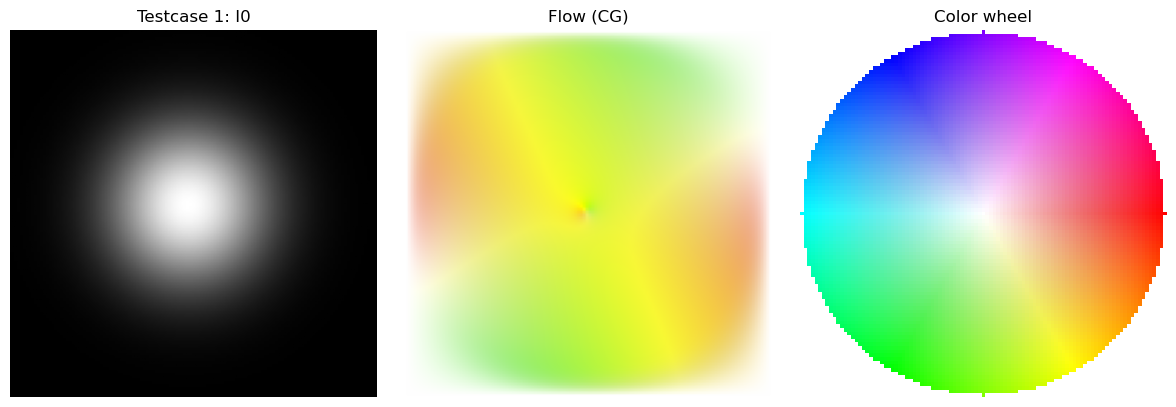


Center region mean flow (CG):
  u_mean ≈ 2.269, v_mean ≈ 4.544
True translation (in pixels):
  u_true = 5.120, v_true = 2.560
Visually check that flow decays to ~0 near the boundaries.

=== Synthetic Test 2: Two Gaussians circling ===
N = 2^k, k = 6..9, lambda_k = 4^(k-4)

--- k = 6, N = 64 ---
CG:   it= 479, relres=9.19e-09, time=0.055s
MG   (s1=1, s2=1, L=3): cycles= 25, relres=8.60e-09, time=0.087s, converged=True
PCG  (s1=1, s2=1, L=3): it=  13, relres=5.32e-09, time=0.047s, converged=True
MG   (s1=2, s2=2, L=3): cycles= 18, relres=9.67e-09, time=0.067s, converged=True
PCG  (s1=2, s2=2, L=3): it=  10, relres=4.40e-09, time=0.040s, converged=True
MG   (s1=3, s2=3, L=3): cycles= 13, relres=6.33e-09, time=0.053s, converged=True
PCG  (s1=3, s2=3, L=3): it=   8, relres=2.13e-09, time=0.037s, converged=True

--- k = 7, N = 128 ---
CG:   it= 415, relres=9.90e-09, time=0.136s
MG   (s1=1, s2=1, L=3): cycles= 31, relres=9.27e-09, time=0.290s, converged=True
PCG  (s1=1, s2=1, L=3): it=  14, 

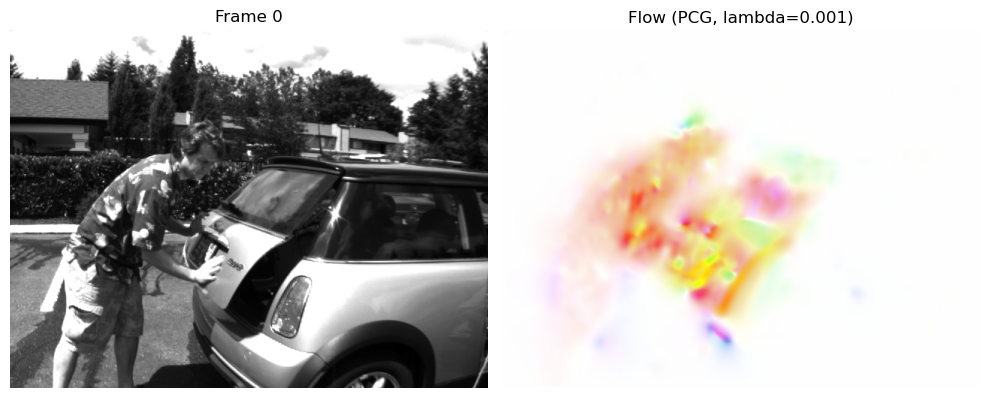


--- lambda = 0.25 ---
CG it=  10 relres=2.069e+00
CG it=  20 relres=1.883e+00
CG it=  30 relres=1.853e+00
CG it=  40 relres=1.564e+00
CG it=  50 relres=1.377e+00
CG it=  60 relres=1.204e+00
CG it=  70 relres=9.951e-01
CG it=  80 relres=8.548e-01
CG it=  90 relres=7.393e-01
CG it= 100 relres=6.936e-01
CG it= 110 relres=6.195e-01
CG it= 120 relres=5.388e-01
CG it= 130 relres=4.664e-01
CG it= 140 relres=4.015e-01
CG it= 150 relres=3.404e-01
CG it= 160 relres=2.855e-01
CG it= 170 relres=2.459e-01
CG it= 180 relres=2.184e-01
CG it= 190 relres=1.948e-01
CG it= 200 relres=1.739e-01
CG it= 210 relres=1.556e-01
CG it= 220 relres=1.391e-01
CG it= 230 relres=1.221e-01
CG it= 240 relres=1.063e-01
CG it= 250 relres=9.306e-02
CG it= 260 relres=8.063e-02
CG it= 270 relres=7.065e-02
CG it= 280 relres=6.138e-02
CG it= 290 relres=5.370e-02
CG it= 300 relres=4.788e-02
CG it= 310 relres=4.205e-02
CG it= 320 relres=3.798e-02
CG it= 330 relres=3.517e-02
CG it= 340 relres=3.222e-02
CG it= 350 relres=2.863e-

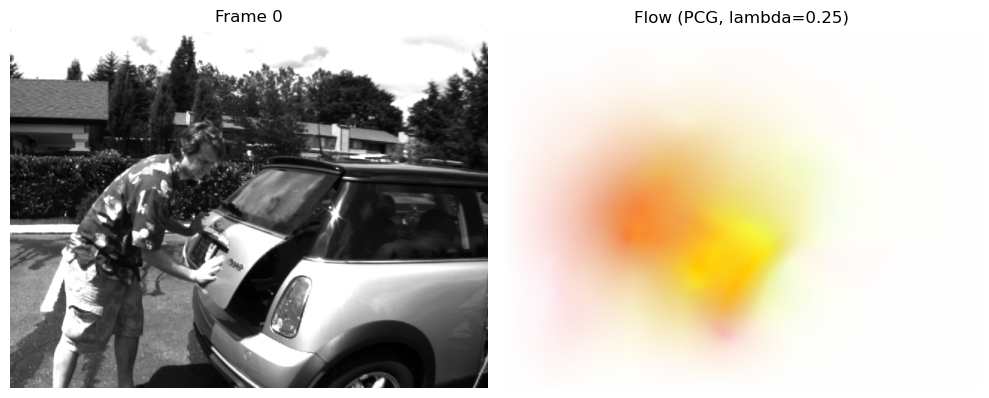


--- lambda = 1.0 ---
CG it=  10 relres=2.767e+00
CG it=  20 relres=2.727e+00
CG it=  30 relres=2.906e+00
CG it=  40 relres=2.703e+00
CG it=  50 relres=2.524e+00
CG it=  60 relres=2.343e+00
CG it=  70 relres=2.038e+00
CG it=  80 relres=1.865e+00
CG it=  90 relres=1.724e+00
CG it= 100 relres=1.708e+00
CG it= 110 relres=1.636e+00
CG it= 120 relres=1.516e+00
CG it= 130 relres=1.394e+00
CG it= 140 relres=1.270e+00
CG it= 150 relres=1.145e+00
CG it= 160 relres=1.019e+00
CG it= 170 relres=9.124e-01
CG it= 180 relres=8.376e-01
CG it= 190 relres=7.630e-01
CG it= 200 relres=6.938e-01
CG it= 210 relres=6.327e-01
CG it= 220 relres=5.784e-01
CG it= 230 relres=5.270e-01
CG it= 240 relres=4.818e-01
CG it= 250 relres=4.469e-01
CG it= 260 relres=4.084e-01
CG it= 270 relres=3.718e-01
CG it= 280 relres=3.363e-01
CG it= 290 relres=2.990e-01
CG it= 300 relres=2.686e-01
CG it= 310 relres=2.413e-01
CG it= 320 relres=2.180e-01
CG it= 330 relres=2.013e-01
CG it= 340 relres=1.846e-01
CG it= 350 relres=1.655e-0

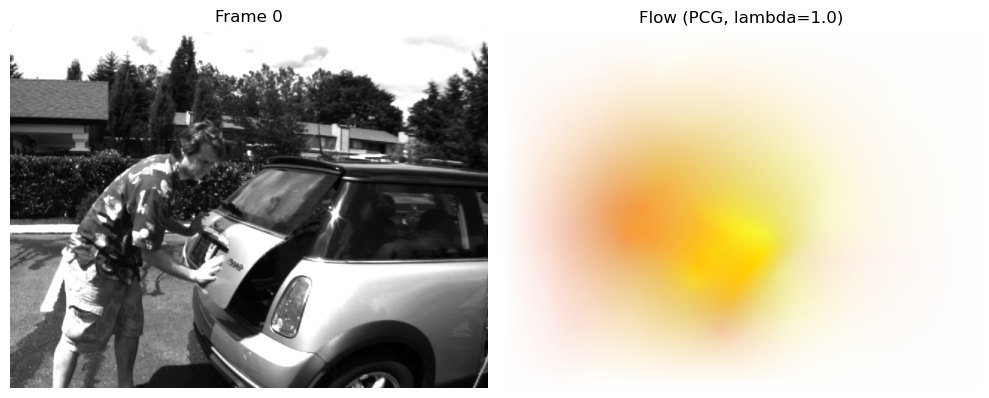


--- lambda = 4.0 ---
CG it=  10 relres=3.043e+00
CG it=  20 relres=3.122e+00
CG it=  30 relres=3.464e+00
CG it=  40 relres=3.391e+00
CG it=  50 relres=3.315e+00
CG it=  60 relres=3.209e+00
CG it=  70 relres=2.877e+00
CG it=  80 relres=2.707e+00
CG it=  90 relres=2.585e+00
CG it= 100 relres=2.651e+00
CG it= 110 relres=2.651e+00
CG it= 120 relres=2.563e+00
CG it= 130 relres=2.454e+00
CG it= 140 relres=2.319e+00
CG it= 150 relres=2.162e+00
CG it= 160 relres=1.991e+00
CG it= 170 relres=1.839e+00
CG it= 180 relres=1.744e+00
CG it= 190 relres=1.639e+00
CG it= 200 relres=1.535e+00
CG it= 210 relres=1.436e+00
CG it= 220 relres=1.337e+00
CG it= 230 relres=1.234e+00
CG it= 240 relres=1.144e+00
CG it= 250 relres=1.083e+00
CG it= 260 relres=1.024e+00
CG it= 270 relres=9.707e-01
CG it= 280 relres=9.155e-01
CG it= 290 relres=8.451e-01
CG it= 300 relres=7.807e-01
CG it= 310 relres=7.173e-01
CG it= 320 relres=6.609e-01
CG it= 330 relres=6.203e-01
CG it= 340 relres=5.776e-01
CG it= 350 relres=5.236e-0

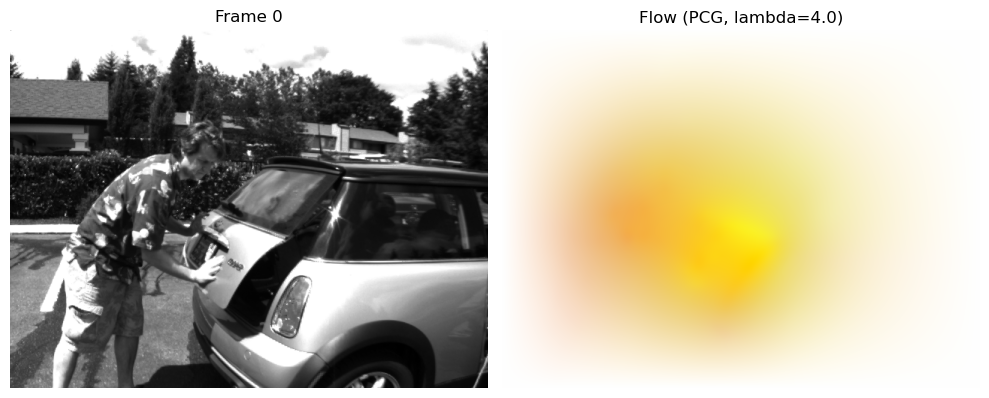


--- lambda = 16.0 ---
CG it=  10 relres=3.122e+00
CG it=  20 relres=3.244e+00
CG it=  30 relres=3.646e+00
CG it=  40 relres=3.632e+00
CG it=  50 relres=3.610e+00
CG it=  60 relres=3.555e+00
CG it=  70 relres=3.231e+00
CG it=  80 relres=3.078e+00
CG it=  90 relres=2.978e+00
CG it= 100 relres=3.098e+00
CG it= 110 relres=3.152e+00
CG it= 120 relres=3.102e+00
CG it= 130 relres=3.024e+00
CG it= 140 relres=2.907e+00
CG it= 150 relres=2.756e+00
CG it= 160 relres=2.578e+00
CG it= 170 relres=2.417e+00
CG it= 180 relres=2.326e+00
CG it= 190 relres=2.220e+00
CG it= 200 relres=2.110e+00
CG it= 210 relres=2.003e+00
CG it= 220 relres=1.887e+00
CG it= 230 relres=1.759e+00
CG it= 240 relres=1.644e+00
CG it= 250 relres=1.570e+00
CG it= 260 relres=1.503e+00
CG it= 270 relres=1.445e+00
CG it= 280 relres=1.386e+00
CG it= 290 relres=1.301e+00
CG it= 300 relres=1.221e+00
CG it= 310 relres=1.138e+00
CG it= 320 relres=1.062e+00
CG it= 330 relres=1.009e+00
CG it= 340 relres=9.502e-01
CG it= 350 relres=8.710e-

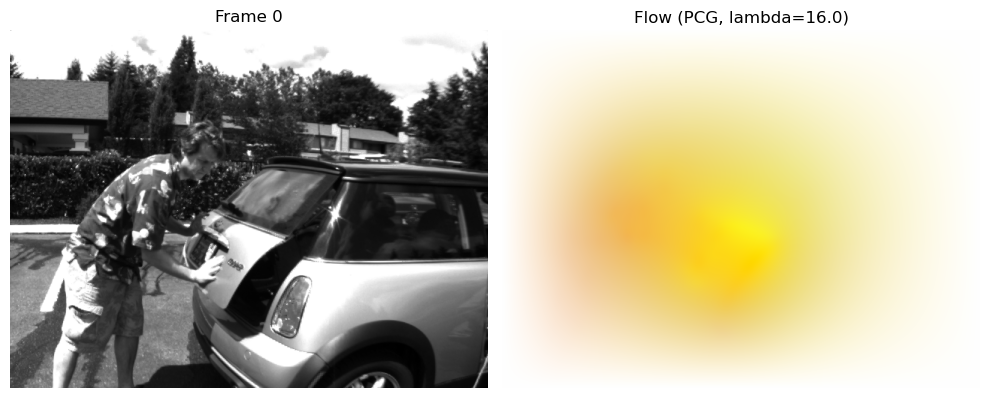


Real image results:
  method  lambda    it        relres
0     CG   0.001   648  9.855765e-09
1    PCG   0.001    12  6.373528e-09
2     CG   0.250  1422  9.851033e-09
3    PCG   0.250    12  9.143020e-09
4     CG   1.000  1885  9.965844e-09
5    PCG   1.000    12  7.511859e-09
6     CG   4.000  2000  6.023099e-07
7    PCG   4.000    12  6.490166e-09
8     CG  16.000  2000  2.219768e-06
9    PCG  16.000    12  4.972915e-09

=== Visualizing Testcase 2, N=128, lambda=64, method=PCG ===
{'it': 11, 'relres': np.float64(7.766618737825884e-09), 'converged': np.True_, 'res_hist': [1.0, np.float64(0.02254886964017057), np.float64(0.0038685630196323155), np.float64(0.0018000545231277609), np.float64(0.00026160969831265845), np.float64(8.577620450731583e-05), np.float64(3.757092853115842e-05), np.float64(4.758302486663166e-06), np.float64(1.7405891151785977e-06), np.float64(5.289168231473848e-07), np.float64(8.289662320609916e-08), np.float64(3.2878169915229975e-08), np.float64(7.76661873782588

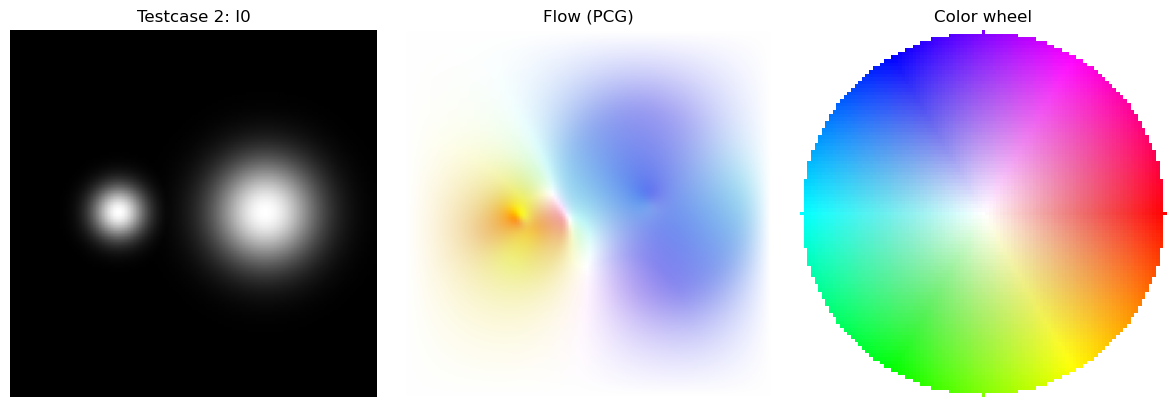

In [28]:
"""
Testing script for optical flow project.

Assumes the following are defined *above* in this file:
- OF_cg, OF_pcg, V_cycle, A, residual_MG, pad_to_multiple_of_2L
- derivatives, build_right_hand_side, zero_boundary
- run_optical_flow, run_optical_flow_pcg
- mycomputeColor, mycolorwheel, generate_test_image

This script answers the numerical testing tasks from the project:
1) Synthetic test 1: one Gaussian moving down-right.
2) Synthetic test 2: two Gaussians circling, N = 2^k, k=6..9, lambda_k = 4^(k-4).
3) Real-image tests on frame10.png / frame11.png (and others if desired).
"""

import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# ---------------------------------------------------------------------
#  Small wrappers around your solvers (for array-based images)
# ---------------------------------------------------------------------

def solve_of_cg_from_arrays(I0, I1, lam, sigma=0.0, tol=1e-8, maxit=2000, verbose=False):
    """
    Solve optical flow with *pure CG* (OF_cg) starting from numpy arrays I0, I1.
    Returns (u, v, info) where info contains 'it', 'relres', 'converged', 'time'.
    """
    # optional smoothing
    from scipy.ndimage import gaussian_filter  # already imported earlier, but safe
    if sigma > 0:
        I0 = gaussian_filter(I0, sigma)
        I1 = gaussian_filter(I1, sigma)

    Ix, Iy = derivatives(I0, I1)
    It = I1 - I0
    rhsu, rhsv = build_right_hand_side(Ix, Iy, It)
    u0 = np.zeros_like(I0)
    v0 = np.zeros_like(I0)

    t0 = time.perf_counter()
    u, v, info = OF_cg(u0, v0, Ix, Iy, lam, rhsu, rhsv,
                       tol=tol, maxit=maxit, verbose=verbose)
    t1 = time.perf_counter()
    info["time"] = t1 - t0
    info["shape"] = I0.shape
    return u, v, info


def solve_of_pcg_from_arrays(I0, I1, lam,
                             sigma=0.0, tol=1e-8, maxit=2000,
                             s1=2, s2=2, max_level=3,
                             verbose=False):
    """
    Solve optical flow with *PCG + MG* (OF_pcg) starting from numpy arrays I0, I1.
    """
    from scipy.ndimage import gaussian_filter
    if sigma > 0:
        I0 = gaussian_filter(I0, sigma)
        I1 = gaussian_filter(I1, sigma)

    # Pad for multigrid (coarser levels)
    I0 = pad_to_multiple_of_2L(I0, max_level)
    I1 = pad_to_multiple_of_2L(I1, max_level)

    Ix, Iy = derivatives(I0, I1)
    It = I1 - I0
    rhsu, rhsv = build_right_hand_side(Ix, Iy, It)
    u0 = np.zeros_like(I0)
    v0 = np.zeros_like(I0)

    t0 = time.perf_counter()
    u, v, info = OF_pcg(
        u0, v0, Ix, Iy, lam, rhsu, rhsv,
        tol=tol, maxit=maxit,
        s1=s1, s2=s2, max_level=max_level,
        verbose=verbose
    )
    t1 = time.perf_counter()
    info["time"] = t1 - t0
    info["shape"] = I0.shape
    info["s1"] = s1
    info["s2"] = s2
    info["max_level"] = max_level
    return u, v, info


def solve_of_mg_iterative_from_arrays(I0, I1, lam,
                                      sigma=0.0, tol=1e-8,
                                      max_cycles=50,
                                      s1=2, s2=2, max_level=3,
                                      verbose=False):
    """
    Use *multigrid V-cycle as a standalone solver*:
    - Start from (u0,v0) = (0,0)
    - Repeatedly apply one V_cycle until ||r_k||/||r_0|| < tol
      or max_cycles is reached.

    This is the "MG" method as an iterative solver.

    Returns (u, v, info) where info['cycles'] is the number of V-cycles used.
    """

    from scipy.ndimage import gaussian_filter
    if sigma > 0:
        I0 = gaussian_filter(I0, sigma)
        I1 = gaussian_filter(I1, sigma)

    I0 = pad_to_multiple_of_2L(I0, max_level)
    I1 = pad_to_multiple_of_2L(I1, max_level)

    Ix, Iy = derivatives(I0, I1)
    It = I1 - I0
    rhsu, rhsv = build_right_hand_side(Ix, Iy, It)
    u = np.zeros_like(I0)
    v = np.zeros_like(I0)

    # Residual at start (level = 0)
    rhu, rhv = residual_MG(u, v, Ix, Iy, lam, rhsu, rhsv, level=0)

    def dot2(a1, a2, b1, b2):
        return float(np.vdot(a1, b1) + np.vdot(a2, b2))

    r2_0 = dot2(rhu, rhv, rhu, rhv)
    rnorm0 = np.sqrt(r2_0)
    if rnorm0 == 0.0:
        return u, v, {"cycles": 0, "relres": 0.0, "converged": True, "time": 0.0}

    t0 = time.perf_counter()
    rel = 1.0
    n_cycles = 0
    while n_cycles < max_cycles and rel > tol:
        # One V-cycle
        u, v = V_cycle(u, v, Ix, Iy, lam, rhsu, rhsv,
                       s1, s2, level=0, max_level=max_level, parity=0)
        # New residual
        rhu, rhv = residual_MG(u, v, Ix, Iy, lam, rhsu, rhsv, level=0)
        r2 = dot2(rhu, rhv, rhu, rhv)
        rel = np.sqrt(r2) / rnorm0
        n_cycles += 1
        if verbose:
            print(f"[MG] cycle={n_cycles:3d}, relres={rel:.3e}")

    t1 = time.perf_counter()
    info = {
        "cycles": n_cycles,
        "relres": rel,
        "converged": rel <= tol,
        "time": t1 - t0,
        "shape": I0.shape,
        "s1": s1,
        "s2": s2,
        "max_level": max_level
    }
    return u, v, info

# ---------------------------------------------------------------------
#  1) Synthetic test 1: One Gaussian moving down-right
# ---------------------------------------------------------------------

def test_case1_single_gaussian():
    """
    Testcase 1 from generate_test_image:
    One Gaussian moving to the lower right.

    Requirements:
    - N x N image
    - Flow in the center should approximately match the translation
    - Flow tends to zero at the boundary (Dirichlet BC)
    """

    from math import sqrt
    N = 128
    I0, I1 = generate_test_image(N, testcase=1)

    lam = 1.0
    sigma = 0.0  # no smoothing needed for synthetic case

    print("\n=== Synthetic Test 1: One Gaussian moving down-right ===")
    print(f"N = {N}, lambda = {lam}")

    # Run CG
    u_cg, v_cg, info_cg = solve_of_cg_from_arrays(
        I0, I1, lam, sigma=sigma, tol=1e-8, maxit=2000, verbose=False
    )
    print("CG info:", info_cg)

    # Run PCG+MG
    u_pcg, v_pcg, info_pcg = solve_of_pcg_from_arrays(
        I0, I1, lam, sigma=sigma, tol=1e-8, maxit=2000,
        s1=2, s2=2, max_level=3, verbose=False
    )
    print("PCG+MG info:", info_pcg)

    # Visualize CG flow
    flow_cg = mycomputeColor(u_cg, v_cg)
    wheel = mycolorwheel(50)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Testcase 1: I0")
    plt.imshow(I0, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Flow (CG)")
    plt.imshow(flow_cg)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Color wheel")
    plt.imshow(wheel)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    # Quantitative check in the center
    c0 = N // 4
    c1 = 3 * N // 4
    u_center = u_cg[c0:c1, c0:c1]
    v_center = v_cg[c0:c1, c0:c1]
    u_mean = np.mean(u_center)
    v_mean = np.mean(v_center)

    # True motion used in generate_test_image (in pixels)
    dx = 0.04
    dy = 0.02
    u_true = N * dx
    v_true = N * dy

    print("\nCenter region mean flow (CG):")
    print(f"  u_mean ≈ {u_mean:.3f}, v_mean ≈ {v_mean:.3f}")
    print("True translation (in pixels):")
    print(f"  u_true = {u_true:.3f}, v_true = {v_true:.3f}")
    print("Visually check that flow decays to ~0 near the boundaries.")


# ---------------------------------------------------------------------
#  2) Synthetic test 2: Two Gaussians circling, scaling study
# ---------------------------------------------------------------------

def run_experiment_two_gaussians(k, method="CG",
                                 sigma=0.0,
                                 s1=2, s2=2, max_level=3,
                                 tol=1e-8, maxit=2000,
                                 verbose=False):
    """
    Run one experiment for testcase=2, image size N=2^k, lambda_k = 4^(k-4)
    method in {"CG", "MG", "PCG"}.
    Returns info dict with timing, iteration counts, etc.
    """
    N = 2**k
    lam = 4**(k - 4)
    I0, I1 = generate_test_image(N, testcase=2)

    if method == "CG":
        u, v, info = solve_of_cg_from_arrays(
            I0, I1, lam, sigma=sigma, tol=tol, maxit=maxit, verbose=verbose
        )
        info["method"] = "CG"
        info["N"] = N
        info["lambda"] = lam
        return info

    elif method == "PCG":
        u, v, info = solve_of_pcg_from_arrays(
            I0, I1, lam, sigma=sigma, tol=tol, maxit=maxit,
            s1=s1, s2=s2, max_level=max_level,
            verbose=verbose
        )
        info["method"] = "PCG"
        info["N"] = N
        info["lambda"] = lam
        return info

    elif method == "MG":
        u, v, info = solve_of_mg_iterative_from_arrays(
            I0, I1, lam, sigma=sigma, tol=tol,
            max_cycles=maxit,  # interpret maxit as max #cycles
            s1=s1, s2=s2, max_level=max_level,
            verbose=verbose
        )
        info["method"] = "MG"
        info["N"] = N
        info["lambda"] = lam
        return info

    else:
        raise ValueError("Unknown method " + method)


def test_case2_two_gaussians():
    """
    Synthetic test 2: Two Gaussians circling around the center.
    N = 2^k, k = 6,...,9, lambda_k = 4^(k-4).

    We test:
    - CG
    - MG (standalone V-cycle iterations)
    - PCG + MG

    For each method and N we report:
    - iteration count / cycles
    - final relative residual
    - CPU time

    We also test several MG parameter choices to see their influence.
    """
    print("\n=== Synthetic Test 2: Two Gaussians circling ===")
    print("N = 2^k, k = 6..9, lambda_k = 4^(k-4)")
    results = []

    ks = [6, 7, 8, 9]
    # MG parameter combos to test
    mg_params = [
        (1, 1, 3),
        (2, 2, 3),
        (3, 3, 3),
    ]

    for k in ks:
        print(f"\n--- k = {k}, N = {2**k} ---")

        # Pure CG
        info_cg = run_experiment_two_gaussians(k, method="CG",
                                               sigma=0.0, tol=1e-8, maxit=2000)
        results.append(info_cg)
        print(f"CG:   it={info_cg['it']:4d}, relres={info_cg['relres']:.2e}, "
              f"time={info_cg['time']:.3f}s")

        # MG standalone + PCG + MG with different parameters
        for (s1, s2, max_level) in mg_params:
            info_mg = run_experiment_two_gaussians(
                k, method="MG", sigma=0.0, tol=1e-8,
                maxit=50, s1=s1, s2=s2, max_level=max_level
            )
            results.append(info_mg)
            print(f"MG   (s1={s1}, s2={s2}, L={max_level}): "
                  f"cycles={info_mg['cycles']:3d}, relres={info_mg['relres']:.2e}, "
                  f"time={info_mg['time']:.3f}s, converged={info_mg['converged']}")

            info_pcg = run_experiment_two_gaussians(
                k, method="PCG", sigma=0.0, tol=1e-8, maxit=2000,
                s1=s1, s2=s2, max_level=max_level
            )
            results.append(info_pcg)
            print(f"PCG  (s1={s1}, s2={s2}, L={max_level}): "
                  f"it={info_pcg['it']:4d}, relres={info_pcg['relres']:.2e}, "
                  f"time={info_pcg['time']:.3f}s, converged={info_pcg['converged']}")

    # Results is a list of dictionaries that you can easily dump into a table in your report.
    # If you have pandas installed, you can also do:
    try:
        import pandas as pd
        df = pd.DataFrame(results)
        print("\nSummary table (first few rows):")
        print(df.head())
        return results
    except ImportError:
        print("\nInstall pandas if you want a nice DataFrame summary of 'results'.")


# ---------------------------------------------------------------------
#  3) Real-image test: frame10.png / frame11.png
# ---------------------------------------------------------------------

def test_real_images(frame0_path, frame1_path):
    """
    Real image test for frame10.png and frame11.png (or any other pair).

    We test CG and PCG+MG for several lambda values and compare:
    - iteration counts
    - final residual
    - CPU times
    """
    print("\n=== Real-image test on", frame0_path, "and", frame1_path, "===")

    # You can tune these lambdas
    lambda_list = [0.001, 0.25, 1.0, 4.0, 16.0]
    sigma = 5.0  # recommended smoothing for natural images
    real_results = []

    for lam in lambda_list:
        print(f"\n--- lambda = {lam} ---")

        # CG
        u_cg, v_cg, info_cg = run_optical_flow(
            frame0_path, frame1_path,
            lam=lam, sigma=sigma, tol=1e-8, maxit=2000
        )
        info_cg["lambda"] = lam
        info_cg["method"] = "CG"
        real_results.append(info_cg)

        # PCG + MG
        u_pcg, v_pcg, info_pcg = run_optical_flow_pcg(
            frame0_path, frame1_path,
            lam=lam, sigma=sigma, tol=1e-8, maxit=2000,
            s1=2, s2=2, max_level=3
        )
        info_pcg["lambda"] = lam
        info_pcg["method"] = "PCG"
        real_results.append(info_pcg)

        print(f"CG:   it={info_cg['it']:4d}, relres={info_cg['relres']:.2e}, "
              f"converged={info_cg['converged']}")
        print(f"PCG:  it={info_pcg['it']:4d}, relres={info_pcg['relres']:.2e}, "
              f"converged={info_pcg['converged']}")

        # Visualize one example flow field for this lambda
        flow_rgb = mycomputeColor(u_pcg, v_pcg)

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.title("Frame 0")
        I0_vis = mpimg.imread(frame0_path)
        if I0_vis.ndim == 3:
            plt.imshow(I0_vis)
        else:
            plt.imshow(I0_vis, cmap="gray")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.title(f"Flow (PCG, lambda={lam})")
        plt.imshow(flow_rgb)
        plt.axis("off")
        plt.tight_layout()
        plt.show()

    # Optional summary as a table
    try:
        import pandas as pd
        df_real = pd.DataFrame(real_results)
        print("\nReal image results:")
        print(df_real[["method", "lambda", "it", "relres"]])
    except ImportError:
        print("\nInstall pandas if you want a DataFrame summary of real_results.")

def visualize_testcase2_flow(N=128, lam=None, method="PCG",
                             sigma=0.0, s1=2, s2=2, max_level=3):
    """
    Compute and display the optical flow for Testcase 2 (two Gaussians circling).
    Default uses PCG+MG.
    """
    # lambda_k = 4^(k-4)
    if lam is None:
        # infer k from N = 2^k
        k = int(np.log2(N))
        lam = 4**(k - 4)

    I0, I1 = generate_test_image(N, testcase=2)

    if method == "CG":
        u, v, info = solve_of_cg_from_arrays(I0, I1, lam, sigma=sigma)
    else:
        u, v, info = solve_of_pcg_from_arrays(
            I0, I1, lam, sigma=sigma,
            s1=s1, s2=s2, max_level=max_level
        )

    print(f"\n=== Visualizing Testcase 2, N={N}, lambda={lam}, method={method} ===")
    print(info)

    # remove padding if PCG padded the arrays
    u = u[:N, :N]
    v = v[:N, :N]

    flow_rgb = mycomputeColor(u, v)
    wheel = mycolorwheel(50)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title("Testcase 2: I0")
    plt.imshow(I0, cmap="gray")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title(f"Flow ({method})")
    plt.imshow(flow_rgb)
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Color wheel")
    plt.imshow(wheel)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------------
#  Main: run all tests
# ---------------------------------------------------------------------

if __name__ == "__main__":
    # 1) Synthetic Gaussian moving to the lower right
    test_case1_single_gaussian()

    # 2) Synthetic two Gaussians circling (scaling study)
    test_case2_two_gaussians()

    # 3) Real-image test on frame10.png / frame11.png
    frame0_path = "/Users/ethanclement/Documents/NLAProject/frame10.png"
    frame1_path = "/Users/ethanclement/Documents/NLAProject/frame11.png"
    test_real_images(frame0_path, frame1_path)

    visualize_testcase2_flow(N=128, method="PCG")



=== Synthetic Test 2: Two Gaussians circling ===
N = 2^k, k = 6..9, lambda_k = 4^(k-4)

--- k = 6, N = 64 ---
CG:   it= 479, relres=9.19e-09, time=0.056s
MG   (s1=1, s2=1, L=3): cycles= 25, relres=8.60e-09, time=0.083s, converged=True
PCG  (s1=1, s2=1, L=3): it=  13, relres=5.32e-09, time=0.047s, converged=True
MG   (s1=2, s2=2, L=3): cycles= 18, relres=9.67e-09, time=0.065s, converged=True
PCG  (s1=2, s2=2, L=3): it=  10, relres=4.40e-09, time=0.040s, converged=True
MG   (s1=3, s2=3, L=3): cycles= 13, relres=6.33e-09, time=0.053s, converged=True
PCG  (s1=3, s2=3, L=3): it=   8, relres=2.13e-09, time=0.037s, converged=True

--- k = 7, N = 128 ---
CG:   it= 415, relres=9.90e-09, time=0.150s
MG   (s1=1, s2=1, L=3): cycles= 31, relres=9.27e-09, time=0.253s, converged=True
PCG  (s1=1, s2=1, L=3): it=  14, relres=2.78e-09, time=0.125s, converged=True
MG   (s1=2, s2=2, L=3): cycles= 24, relres=5.77e-09, time=0.227s, converged=True
PCG  (s1=2, s2=2, L=3): it=  11, relres=7.77e-09, time=0.119

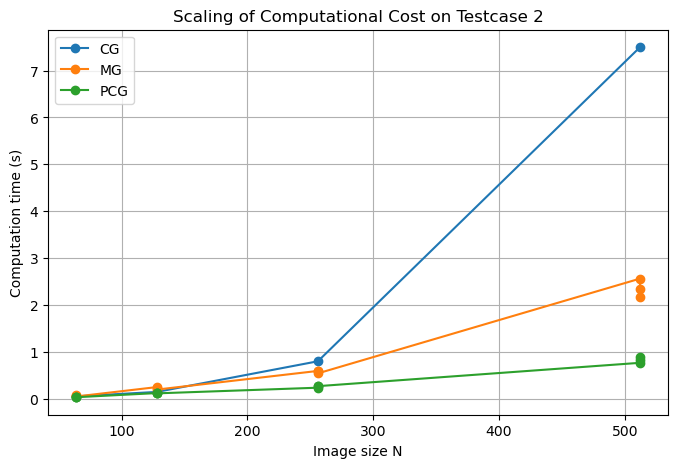

In [23]:
results = test_case2_two_gaussians()
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(results)

plt.figure(figsize=(8,5))
for method in ["CG", "MG", "PCG"]:
    df_method = df[df["method"] == method]
    plt.plot(df_method["N"], df_method["time"], marker="o", label=method)

plt.xlabel("Image size N")
plt.ylabel("Computation time (s)")
plt.title("Scaling of Computational Cost on Testcase 2")
plt.legend()
plt.grid(True)
plt.show()


[{'it': 479, 'relres': np.float64(9.19261384018108e-09), 'converged': np.True_, 'res_hist': [1.0, np.float64(0.4454818852227328), np.float64(0.20674818035767892), np.float64(0.13218923518131032), np.float64(0.09555378255981384), np.float64(0.06686119862080107), np.float64(0.05384240491503259), np.float64(0.044231468389639844), np.float64(0.03739347581322699), np.float64(0.03057328000491815), np.float64(0.027585325941566905), np.float64(0.02476525952021018), np.float64(0.021450164850997582), np.float64(0.019132992451002247), np.float64(0.018456149909479955), np.float64(0.016440344731059847), np.float64(0.015118924510978382), np.float64(0.013797122274205664), np.float64(0.013578867364141255), np.float64(0.01206761696411031), np.float64(0.011394344301611275), np.float64(0.010575621663362561), np.float64(0.009884628961498809), np.float64(0.00925754575828693), np.float64(0.009108156182452838), np.float64(0.00830164174592682), np.float64(0.007750875679950423), np.float64(0.007410198356280095

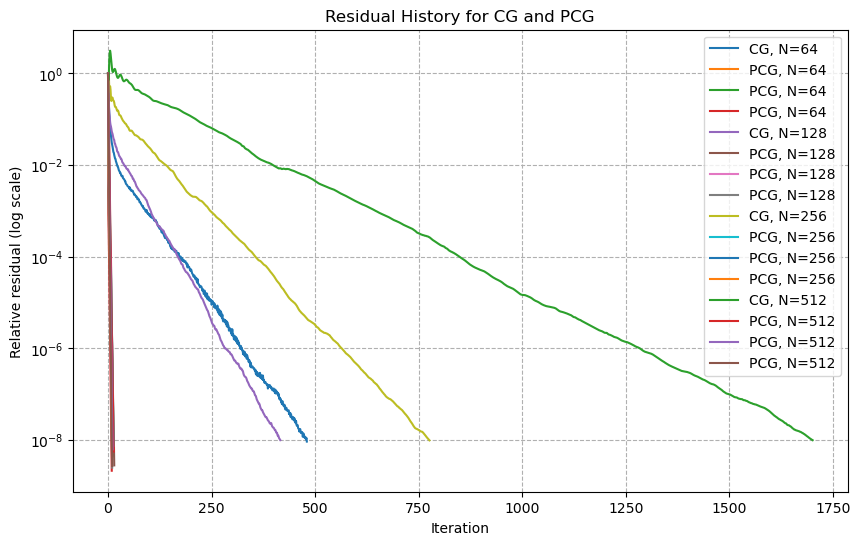

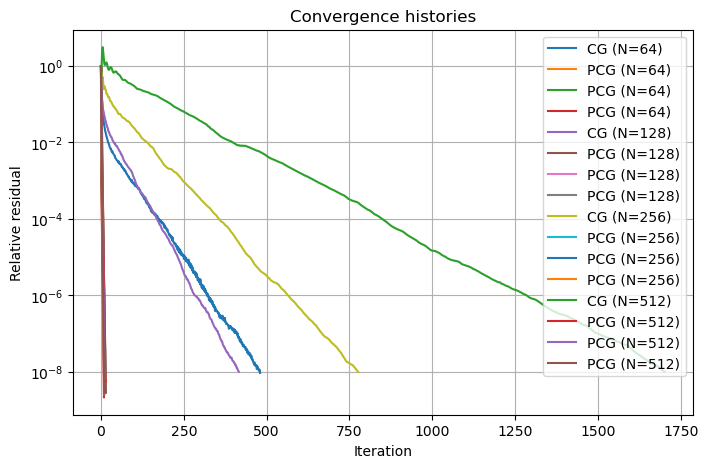

In [24]:
import matplotlib.pyplot as plt
import numpy as np
print(results)
def plot_residual_histories(results):
    plt.figure(figsize=(10,6))

    for entry in results:
        if "res_hist" not in entry:
            continue  
            
        method = entry["method"]
        N = entry["N"]
        res = entry["res_hist"]

        plt.semilogy(res, label=f"{method}, N={N}")

    plt.xlabel("Iteration")
    plt.ylabel("Relative residual (log scale)")
    plt.title("Residual History for CG and PCG")
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.show()

plot_residual_histories(results)

def plot_residual_histories(results):
    plt.figure(figsize=(8,5))

    for r in results:
        if "res_hist" not in r:
            continue  

        label = f"{r['method']} (N={r['N']})"
        plt.semilogy(r["res_hist"], label=label)

    plt.xlabel("Iteration")
    plt.ylabel("Relative residual")
    plt.title("Convergence histories")
    plt.grid(True)
    plt.legend()
    plt.show()
plot_residual_histories(results)





